# Project Overview
This project involves training an image classifier to recognize different species of flowers. The classifier could be used in applications like a phone app that identifies flowers in photos. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.

The project is broken down into these main steps:
 - Load and preprocess the image dataset
 - Train the image classifier on the dataset
 - Use the trained classifier to predict image content

In [15]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import json
import numpy as np
from PIL import Image
import seaborn as seab

## Loading the Data
This project uses `torchvision` to load the flower data ([download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)). The dataset is split into training, validation, and testing sets.

- For the training set, we apply data augmentation techniques like random scaling, cropping, and flipping. This helps the network generalize better. The input data is resized to 224x224 pixels as required by the pre-trained networks.
- The validation and testing sets are used to measure the model's performance on unseen data. These sets only have resizing and cropping transforms applied, not the augmentation transforms used on the training data.

All three sets have their color channels normalized using the means `[0.485, 0.456, 0.406]` and standard deviations `[0.229, 0.224, 0.225]` calculated from the ImageNet dataset. This shifts each color channel to be centered at 0 and range from -1 to 1.

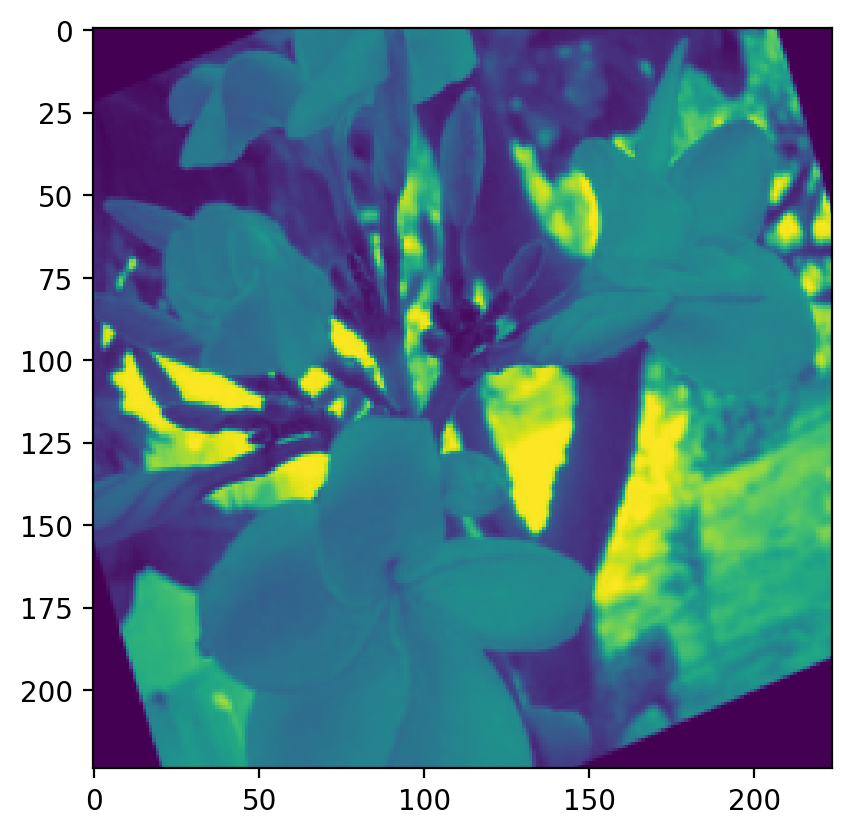

In [16]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_and_validation_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#folder paths
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=test_and_validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_and_validation_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

#checking if trainloader is working
image, label = next(iter(trainloader))
plt.imshow(image[0,0])

### Label mapping
The `cat_to_name.json` file contains a mapping between category labels and category names. This JSON object includes a dictionary that links integer-encoded categories to the corresponding flower names. The json module in Python is used to read and parse this file, providing a convenient way to translate the numerical categories output by the model into human-readable flower names.

This mapping is crucial for interpreting the model's predictions, as it allows for the conversion of numerical outputs into meaningful flower names. By using this dictionary, results can be presented in a user-friendly format, displaying actual flower names instead of their numerical representations.

In [17]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## Building and training the classifier
### Training the Classifier

The classifier is trained on the flower dataset using transfer learning. We use a pre-trained network and modify the classifier layers to output probabilities for the 102 flower categories.

Key steps in the training process include:
 - Freezing parameters of the pre-trained network
 - Defining a new classifier for the 102 output classes
 - Training the classifier layers using the flower training data
 - Tracking the loss and accuracy on the training and validation sets

### Using the Trained Classifier
Once trained, the classifier can be used to predict the content of new images. The process involves:
 - Loading and preprocessing the image
 - Running it through the trained network
 - Interpreting the output probabilities
 - Mapping the predicted class to the corresponding flower name

This trained classifier could then be exported for use in applications to identify flowers in photos.

In [18]:
def create_model(class_to_idx):
    model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

#updating model classfier to a new custom classifier
    model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 102),
                                 nn.LogSoftmax(dim=1))

    model.class_to_idx = train_data.class_to_idx
    return model

In [19]:
#creating model
model = create_model(train_data.class_to_idx)

criterion = nn.NLLLoss()
learning_rate = 0.003
optimizer = optim.Adam(model.fc.parameters(), learning_rate)

#moving to cuda/mps to get gpu access if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"\nAvailable device is: {device}\n")


model.to(device)

/Users/sushmitha047/Documents/AWSxUdacity-Scholarship-Program/AI-Programming-with-Python/Image-Classifer/image-classifier/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sushmitha047/Documents/AWSxUdacity-Scholarship-Program/AI-Programming-with-Python/Image-Classifer/image-classifier/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Available device is: mps



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
def validation_and_testing(data_loader):
        checking_loss = 0
        accuracy = 0
        model.eval()

        # Turn off gradients for validation
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                log_ps = model.forward(inputs)
                checking_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return checking_loss/len(data_loader), accuracy/len(data_loader)

In [21]:
epochs = 10
for e in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        log_ps = model.forward(inputs)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        validation_loss, validation_accuracy = validation_and_testing(validationloader)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss),
              "Validation Accuracy: {:.3f}".format(validation_accuracy))

        running_loss = 0
        model.train()

Epoch: 1/10..  Training Loss: 3.840..  Validation Loss: 2.222..  Validation Accuracy: 0.423
Epoch: 2/10..  Training Loss: 2.313..  Validation Loss: 1.307..  Validation Accuracy: 0.632
Epoch: 3/10..  Training Loss: 1.851..  Validation Loss: 1.110..  Validation Accuracy: 0.708
Epoch: 4/10..  Training Loss: 1.646..  Validation Loss: 0.986..  Validation Accuracy: 0.702
Epoch: 5/10..  Training Loss: 1.531..  Validation Loss: 0.762..  Validation Accuracy: 0.781
Epoch: 6/10..  Training Loss: 1.437..  Validation Loss: 0.770..  Validation Accuracy: 0.790
Epoch: 7/10..  Training Loss: 1.355..  Validation Loss: 0.713..  Validation Accuracy: 0.787
Epoch: 8/10..  Training Loss: 1.354..  Validation Loss: 0.666..  Validation Accuracy: 0.805
Epoch: 9/10..  Training Loss: 1.316..  Validation Loss: 0.651..  Validation Accuracy: 0.808
Epoch: 10/10..  Training Loss: 1.270..  Validation Loss: 0.631..  Validation Accuracy: 0.820


## Testing the Network
The trained network is evaluated on test data, which consists of images the network has never seen during training or validation. This process provides a good estimate of the model's performance on completely new images. The test images are run through the network, and accuracy is measured in the same way as during validation. A well-trained model should achieve around 70% accuracy on the test set.

In [22]:
# TODO: Do validation on the test set
test_loss, test_accuracy = validation_and_testing(testloader)

print("Test Loss: {:.3f}.. ".format(test_loss),
      "Test Accuracy: {:.3f}".format(test_accuracy))

Test Loss: 0.661..  Test Accuracy: 0.808


## Checkpoint Saving
After training the network, the model is saved to allow for later use in making predictions. The checkpoint includes several key components:

1. The trained model's state dictionary
2. The mapping of classes to indices, obtained from the training dataset
3. The number of epochs used in training
4. The optimizer's state dictionary

This comprehensive checkpoint allows for:

- Complete reconstruction of the model for inference
- Resumption of training if desired
- Preservation of important metadata

The class-to-index mapping is attached to the model as an attribute, facilitating easier inference later:

```model.class_to_idx = image_datasets['train'].class_to_idx```


By saving all these elements, the checkpoint ensures that the trained model can be fully utilized in subsequent stages of the project, whether for making predictions or further refinement of the model.

In [23]:
# TODO: Save the checkpoint
checkpoint = {'model': 'resnet50',
              'input_size': 2048,
              'fully_connected': model.fc,
              'output_size': 102,
              'learning_rate': learning_rate,
              'criterion': criterion,
              'epochs': epochs,
              'class_to_index_connection' : model.class_to_idx,
              'optimizer' : optimizer.state_dict(),
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Checkpoint Loading
A function is implemented to load a saved checkpoint and rebuild the model. This allows for resuming work on the project without having to retrain the network.

In [24]:
checkpoint = torch.load('checkpoint.pth')

class_to_idx = checkpoint['class_to_index_connection']
model = create_model(class_to_idx)

model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.to(device)

print(model)

/var/folders/ss/_2h_wp7x63jb4xcfzjnw1pym0000gn/T/ipykernel_33367/2368579100.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Classification Inference

A prediction function is created to use the trained network for inference. This function ```predict``` takes an image and a model as input, then returns the top K most likely classes along with their probabilities.

## Image Preprocessing
Image preprocessing is handled using the ```PIL``` library. A function is created to preprocess images in the same manner used during training. This involves resizing the image, cropping the center portion, converting color values, normalizing the image, and reordering dimensions to match PyTorch's expectations.

In [29]:
def process_image(imagepath):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(imagepath)

    width, height = im.size

    shortest_side = 256
    if width > height:
        ratio = width/height
        height = shortest_side
        width = shortest_side * ratio
    elif height > width:
        ratio = height/width
        width = shortest_side
        height = shortest_side * ratio
    else:
        height = shortest_side
        width = shortest_side

    #resizing
    im.thumbnail((width,height), Image.Resampling.LANCZOS)

    #crop parameters
    x0 = (width - 224) / 2
    y0 = (height - 224) / 2
    x1 = x0 + 224
    y1 = y0 + 224

    #cropping
    im = im.crop((x0, y0, x1, y1))

    image_to_np_array = np.array(im)/255

    #normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = (image_to_np_array - mean)/std

    #adjusting color channel
    final_image = im.transpose((2, 0, 1))

    return final_image

In [30]:
# Function to display the original image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    image = image.transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

<Axes: >

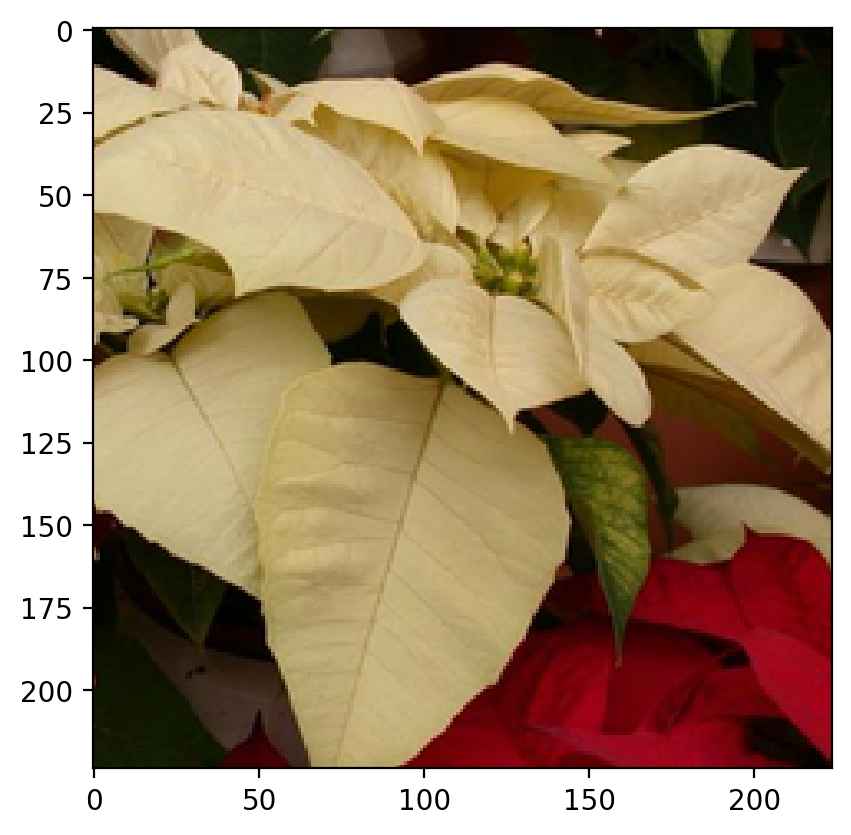

In [31]:
#image_path = test_dir + '/10/image_07090.jpg' - globe
#image_path = test_dir + '/102/image_06657.jpg'
# image_path = test_dir + '/12/image_03994.jpg'
# image_path = test_dir + '/33/image_06470.jpg'
image_path = test_dir + '/44/image_01518.jpg'
image = process_image(image_path)
imshow(image)

## Class Prediction
The class prediction function calculates class probabilities and finds the K largest values. It converts the indices of these probabilities to actual class labels using the class_to_idx mapping.

In [32]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()

    #moving to cuda/mps to get gpu access if available
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    model.to(device)

    array_image = process_image(image_path)
    #getting tensor from array_image
    tensor = torch.from_numpy(array_image).float().unsqueeze(0)
    tensor = tensor.to(device)

    #calcualtions
    log_predictions = model.forward(tensor)
    predictions = torch.exp(log_predictions)
    top_probs, top_classes = predictions.topk(topk)

    #getting arrays
    top_probs = np.array(top_probs.detach().cpu())[0]
    top_classes = np.array(top_classes.detach().cpu())[0]

    #convert to idexies to classes
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    top_classes = [idx_to_class[label] for label in top_classes]
    top_flowers = [cat_to_name[label] for label in top_classes]

    return top_probs, top_classes, top_flowers

## Sanity Checking
To ensure the trained model's predictions make sense, a visualization is created using matplotlib. This plots the probabilities for the top 5 classes as a bar graph, alongside the input image. 

The class integer encoding is converted to actual flower names using the ```cat_to_name.json``` file.

/var/folders/ss/_2h_wp7x63jb4xcfzjnw1pym0000gn/T/ipykernel_33367/2428173699.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  top_probs = np.array(top_probs.detach().cpu())[0]
/var/folders/ss/_2h_wp7x63jb4xcfzjnw1pym0000gn/T/ipykernel_33367/2428173699.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  top_classes = np.array(top_classes.detach().cpu())[0]


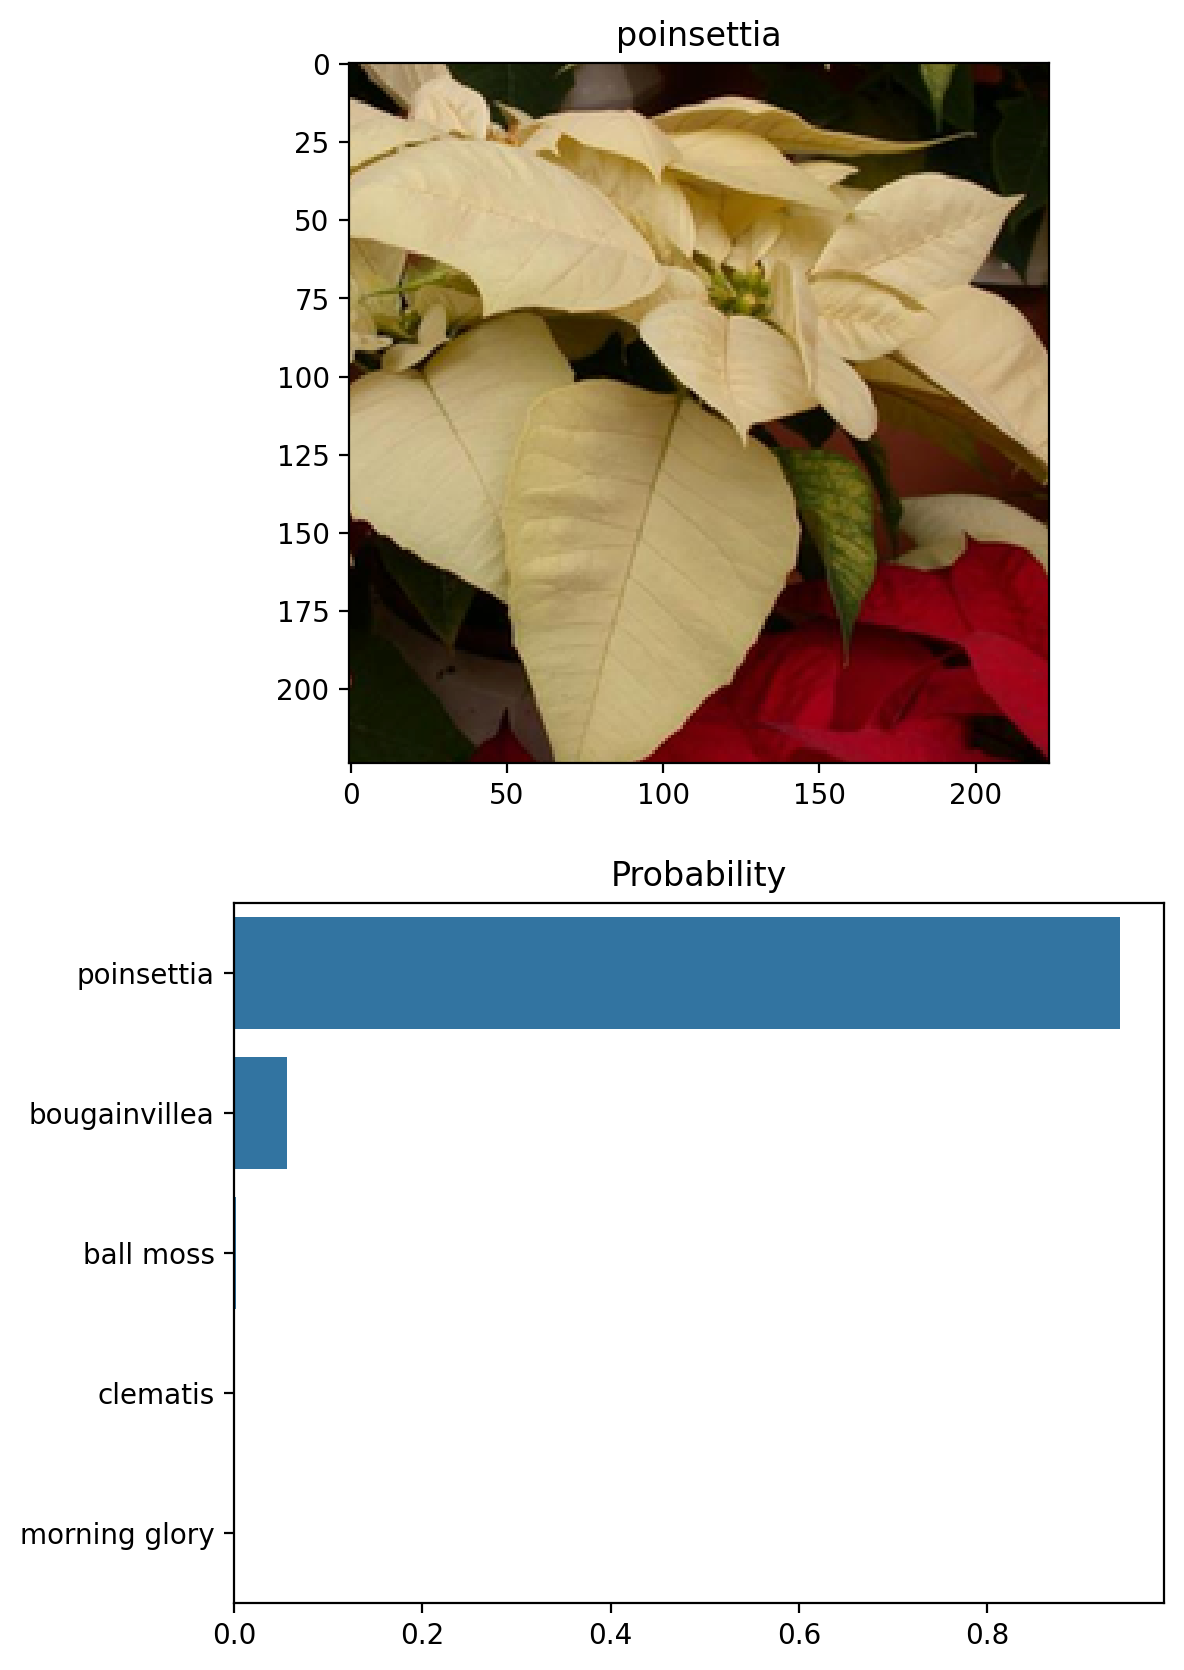

In [33]:
# TODO: Display an image along with the top 5 classes
probabilities, classes, flowers = predict(image_path, model)

#getting name for top probability
max_index = np.argmax(probabilities)
max_probability = probabilities[max_index]
label = classes[max_index]
titel = cat_to_name[label]

plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)
ax.set_title(titel)

img = process_image(image_path)
imshow(img, ax);

ax1 = plt.subplot(2,1,2)
ax1.set_title('Probability')
seab.barplot(x=probabilities, y=flowers, color=seab.color_palette()[0]);
plt.show()